In [ ]:
# Run necessary imports
import matplotlib.pyplot as plt
import torch

from src.data_loading.torch_data_utils import load_data_with_logging
from src.models.residual_preprocess import PreprocessingResidual
from src.models.resnet50 import ResNet
from src.prep_and_processing.processing_utils import (
    apply_smote,
    tensor_to_numpy,
    reshape_for_vit,
    numpy_to_tensor
)
from sklearn.preprocessing import StandardScaler
from src.models.ViT import ViTModel
from torch.utils.data import DataLoader, TensorDataset
from src.retrain_fine_tune.ViT_finetune import fine_tune_model_with_search

/Users/thorpe/.pyenv/versions/MammoViT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data
This cell loads the data and prints the shape of training and validation batches.

In [2]:
# Load data
data_dir = "data/KAU"
dataloaders = load_data_with_logging(data_dir)

# Print the shape of the training data
images_train, labels_train = next(iter(dataloaders['train']))
print(f"Training batch shape: {images_train.shape}")

# Print the shape of the validation data
images_val, labels_val = next(iter(dataloaders['val']))
print(f"Validation batch shape: {images_val.shape}")

Training batch shape: torch.Size([32, 3, 224, 224])
Validation batch shape: torch.Size([32, 3, 224, 224])


# Visualize Class Images
This cell plots one image from each class in the training dataset.

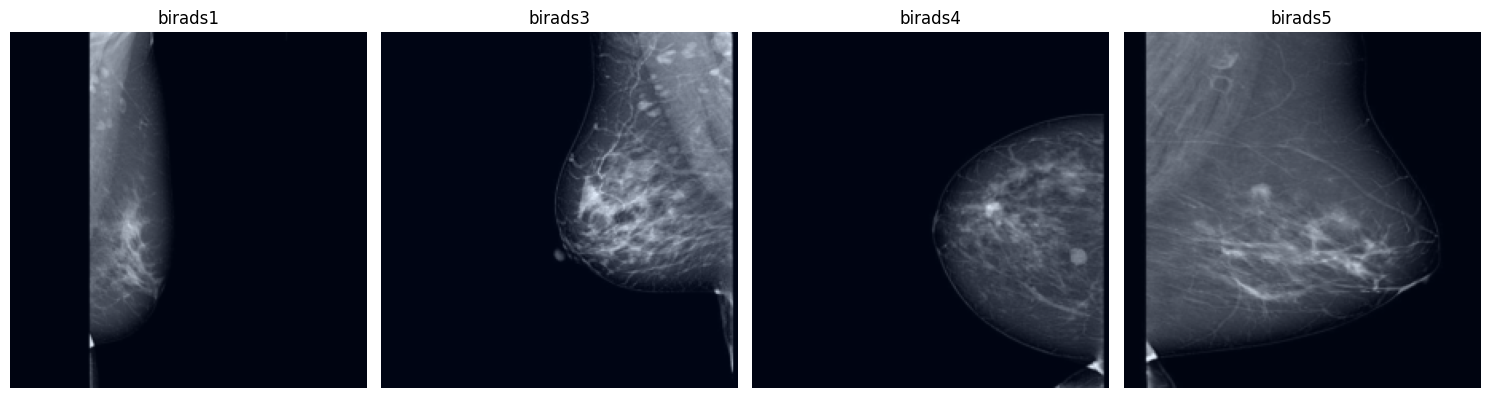

In [3]:
# Get class names
class_names = dataloaders['train'].dataset.classes

# Plot one image from each class
fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

for i, class_name in enumerate(class_names):
    found = False
    for images, labels in dataloaders['train']:
        mask = (labels == i).nonzero(as_tuple=True)[0]
        if mask.numel() > 0:
            idx = mask[0]
            image = images[idx].permute(1, 2, 0).numpy()
            image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
            axes[i].imshow(image)
            axes[i].set_title(class_name)
            axes[i].axis('off')
            found = True
            break
    if not found:
        axes[i].set_title(f"{class_name}\n(Not Found)")
        axes[i].axis('off')
plt.tight_layout()
plt.show()

# Process Data Using PreprocessingResidual
This cell initializes the PreprocessingResidual class, processes the training images, applies a linear projection, and prints the shape of the projected output.

In [5]:
# Initialize the PreprocessingResidual stack
cnn_processor = PreprocessingResidual()

# Process the data using the Residual processor
images_train, labels_train = next(iter(dataloaders['train']))
images_val, labels_val = next(iter(dataloaders['val']))
processed_imgs_train = cnn_processor(images_train)
processed_imgs_val = cnn_processor(images_val)

# Apply linear projection
projected_imgs_train = PreprocessingResidual.linear_projection(processed_imgs_train.size(1), processed_imgs_train)
projected_imgs_val = PreprocessingResidual.linear_projection(processed_imgs_val.size(1), processed_imgs_val)

# Print the shape of the projected output
print(f"Projected training output shape: {projected_imgs_train.shape}")
print(f"Projected validation output shape: {projected_imgs_val.shape}")

Projected training output shape: torch.Size([32, 224, 224, 3])
Projected validation output shape: torch.Size([32, 224, 224, 3])


# Feature Extraction Using ResNet Layer
This cell uses ResNet layer to preprocess images to better extract features for further processing.

In [6]:
featureExtractor = ResNet().get_model()

# Permute needed for [B, 3,224,224] shape model expects
projected_imgs_train = projected_imgs_train.permute(0, 3, 1, 2)
projected_imgs_val = projected_imgs_val.permute(0, 3, 1, 2)

# Extract features from the processed images
extracted_features_train = featureExtractor(projected_imgs_train)
extracted_features_val = featureExtractor(projected_imgs_val)

# Perform global average pooling
pooled_features_train = ResNet.global_average_pooling(extracted_features_train)
pooled_features_val = ResNet.global_average_pooling(extracted_features_val)

# Print the shape of extracted features
print(f"Extracted training features shape: {extracted_features_train.shape}")
print(f"Extracted validation features shape: {extracted_features_val.shape}")

# Print the shape of pooled features
print(f"Pooled training features shape: {pooled_features_train.shape}")
print(f"Pooled validation features shape: {pooled_features_val.shape}")

Extracted training features shape: torch.Size([32, 2048, 7, 7])
Extracted validation features shape: torch.Size([32, 2048, 7, 7])
Pooled training features shape: torch.Size([32, 2048])
Pooled validation features shape: torch.Size([32, 2048])


# Apply SMOTE to Oversample Features and Labels
This cell applies the SMOTE function to oversample features and labels, and prints their shapes.

In [9]:
pooled_features_train_np = tensor_to_numpy(pooled_features_train)
pooled_features_val_np = tensor_to_numpy(pooled_features_val)
labels_np = tensor_to_numpy(labels)

# Apply SMOTE to oversample features and labels
smote_features_train, smote_labels_train = apply_smote(pooled_features_train_np, labels_np)

# Print the shape of the oversampled features and labels
print(f"Oversampled training features shape: {smote_features_train.shape}")
print(f"Oversampled training labels shape: {smote_labels_train.shape}")

# Normalize the SMOTE output
scaler = StandardScaler()
normalized_features_train_np = scaler.fit_transform(smote_features_train) # type: ignore
normalized_features_val_np = scaler.transform(pooled_features_val_np)

# Print the shape of the normalized features
print(f"Normalized training features array shape: {normalized_features_train_np.shape}")
print(f"Normalized validation features array shape: {normalized_features_val_np.shape}")

# Convert augmented arrays to tensors
augmented_features_train = numpy_to_tensor(normalized_features_train_np)
augmented_features_val = numpy_to_tensor(normalized_features_val_np)
augmented_labels_train = numpy_to_tensor(smote_labels_train)
labels_val = numpy_to_tensor(labels_np)

# Print the shape of the augmented tensors
print(f"Augmented training features tensor shape: {augmented_features_train.shape}")
print(f"Augmented training labels tensor shape: {augmented_labels_train.shape}")

print(f"Augmented validation features tensor shape: {augmented_features_val.shape}")
print(f"Augmented validation labels tensor shape: {labels_val.shape}")


Oversampled training features shape: (36, 2048)
Oversampled training labels shape: (36,)
Normalized training features array shape: (36, 2048)
Normalized validation features array shape: (32, 2048)
Augmented training features tensor shape: torch.Size([36, 2048])
Augmented training labels tensor shape: torch.Size([36])
Augmented validation features tensor shape: torch.Size([32, 2048])
Augmented validation labels tensor shape: torch.Size([32])


# Explanation of Batch Size Change
The batch size changed from 32 to 44 after reshaping for ViT due to the SMOTE oversampling process.

SMOTE generates synthetic samples to balance the dataset by oversampling minority classes. This increases the total number of samples in the batch, resulting in a larger batch size.

In this case, the original batch size of 32 was augmented with additional samples, leading to a new batch size of 44. The reshaping operation reflects this updated batch size.

In [10]:
# Reshape augmented features for ViT
vit_ready_features_train = reshape_for_vit(augmented_features_train)
vit_ready_features_val = reshape_for_vit(augmented_features_val)

print(f"ViT-ready training features shape: {vit_ready_features_train.shape}")
print(f"ViT-ready validation features shape: {vit_ready_features_val.shape}")

ViT-ready training features shape: torch.Size([36, 16, 16, 8])
ViT-ready validation features shape: torch.Size([32, 16, 16, 8])


In [ ]:
# Prepare datasets
train_dataset = TensorDataset(vit_ready_features_train, augmented_labels_train)
val_dataset = TensorDataset(vit_ready_features_val, labels_val)

# Prepare loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
num_classes = len(torch.unique(labels_val))
vit_model = ViTModel(num_classes=num_classes).model

# Fine-tune
fine_tune_model_with_search(
    model=vit_model,
    train_loader=train_loader,
    val_loader=val_loader,
    tuner_epochs=50,
)
